Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [174]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil

In [175]:
## remove the existing zip file
shutil.rmtree('/content/CNN_assignment.zip', ignore_errors=True)

In [176]:
## If you are using the data by mounting the google drive, use the following :
!pip install gdown
import gdown
url="https://drive.google.com/uc?id=1Y-zrnB-P15z4iCbUKzFvi7_zF5eJ9gTp"
output = "CNN_assignment.zip"
gdown.download(url, output, quiet=False)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Downloading...
From: https://drive.google.com/uc?id=1Y-zrnB-P15z4iCbUKzFvi7_zF5eJ9gTp
To: /content/CNN_assignment.zip
824MB [00:03, 214MB/s]


'CNN_assignment.zip'

In [177]:
## unzip the downloaded folder
shutil.rmtree('/content/CNN_assignment', ignore_errors=True)
shutil.unpack_archive("CNN_assignment.zip", "CNN_assignment")

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [178]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [179]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [180]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [181]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [182]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [183]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

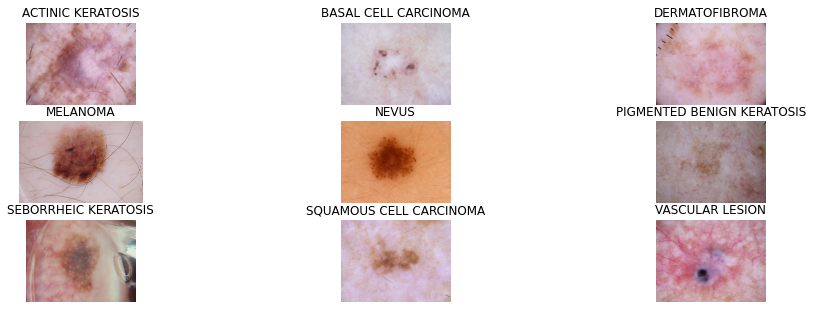

In [184]:
from os import listdir
from os.path import join
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
### showing images directly from the folders without resizing
%matplotlib inline
image_indexes = [0]
selected_image_file_paths = {}
for classification in class_names:
    image_directory = join(data_dir_train, classification)
    image_file_names = listdir(image_directory)
    selected_image_file_paths[classification] = [join(image_directory, image_file_names[i]) for i in image_indexes]

number_classes = len(class_names)
plt.figure(figsize=(16,16))    
for i,classification in enumerate(class_names):
    for j,image in enumerate(selected_image_file_paths[classification]):
        image_number = (i * len(image_indexes)) + j + 1
        ax = plt.subplot(number_classes,3,image_number)
        plt.title(classification.upper())
        plt.axis("off")
        plt.imshow(mpimg.imread(image))



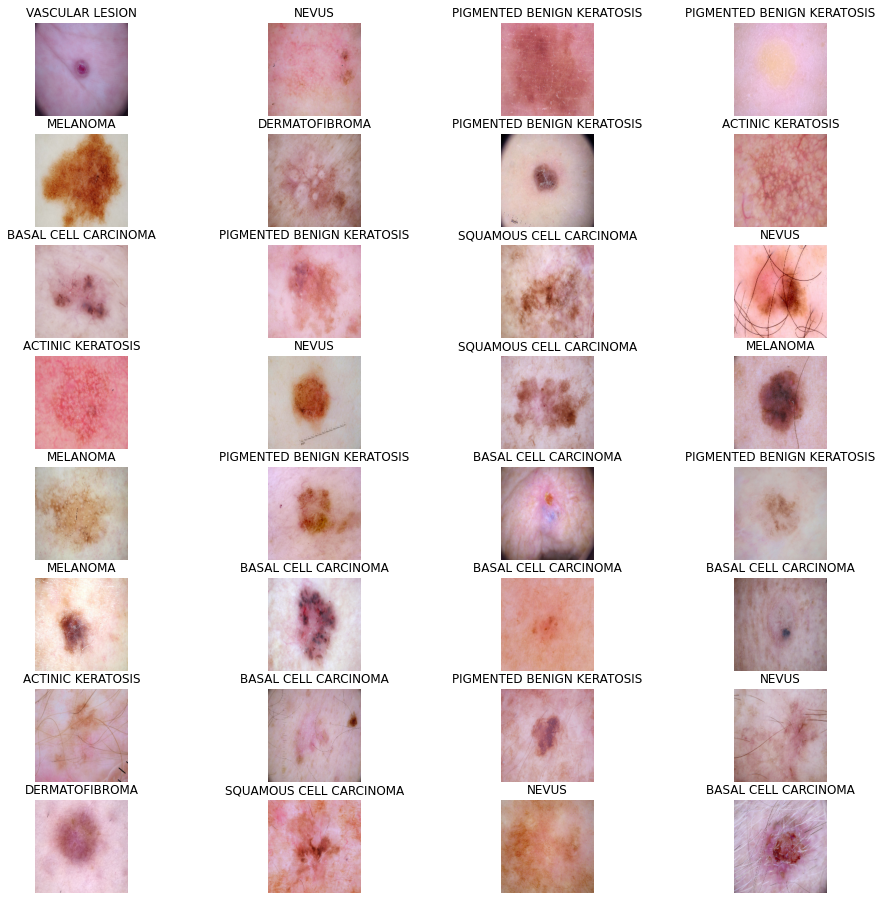

In [185]:
import matplotlib.pyplot as plt
## Show images from the first batch
## batch_size=32 
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(batch_size):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]].upper())
    plt.axis("off")


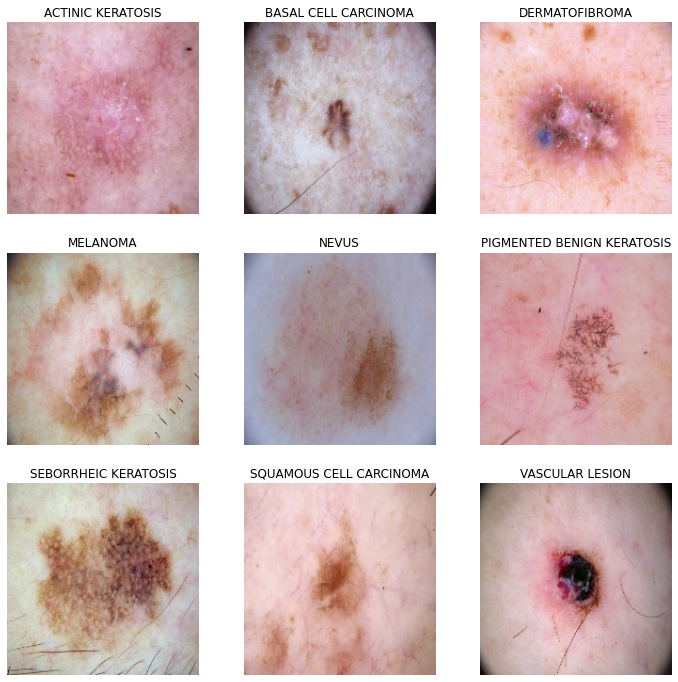

In [186]:
## Visualize one instanes of all the data set from the training data set + all batches
def get_images():
  d_dict = ()
  for images, labels in train_ds:
      for i in range(batch_size):
          if class_names[labels[i]] not in dict.keys():
              dict[class_names[labels[i]]]= images[i]
  return dict

def show_images():
    d_dict = get_images()
    plt.figure(figsize=(12, 12))
    for label in class_names:
        ax = plt.subplot(3, 3, class_names.index(label) + 1)
        plt.imshow(dict[label].numpy().astype("uint8"))
        plt.title(label.upper())
        plt.axis("off")

show_images()
        

In [187]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [188]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
x_train_ds = train_ds
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [189]:
num_classes = len(class_names)

print(num_classes)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


9


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [190]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [191]:
# View the summary of all layers
model.summary()


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 22, 22, 64)      

### Train the model

In [192]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
56/56 [==============================] - 16s 74ms/step - loss: 2.0739 - accuracy: 0.2019 - val_loss: 1.7623 - val_accuracy: 0.3736
Epoch 2/20
56/56 [==============================] - 1s 21ms/step - loss: 1.7364 - accuracy: 0.3511 - val_loss: 1.6215 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 1s 20ms/step - loss: 1.5102 - accuracy: 0.4785 - val_loss: 1.4060 - val_accuracy: 0.5145
Epoch 4/20
56/56 [==============================] - 1s 20ms/step - loss: 1.3421 - accuracy: 0.5489 - val_loss: 1.4151 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 20ms/step - loss: 1.2331 - accuracy: 0.5684 - val_loss: 1.3985 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 1s 20ms/step - loss: 1.1840 - accuracy: 0.5792 - val_loss: 1.3678 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 20ms/step - loss: 1.0559 - accuracy: 0.6297 - val_loss: 1.3994 - val_accuracy: 0.5369
Epoch 8/20
5

### Visualizing training results

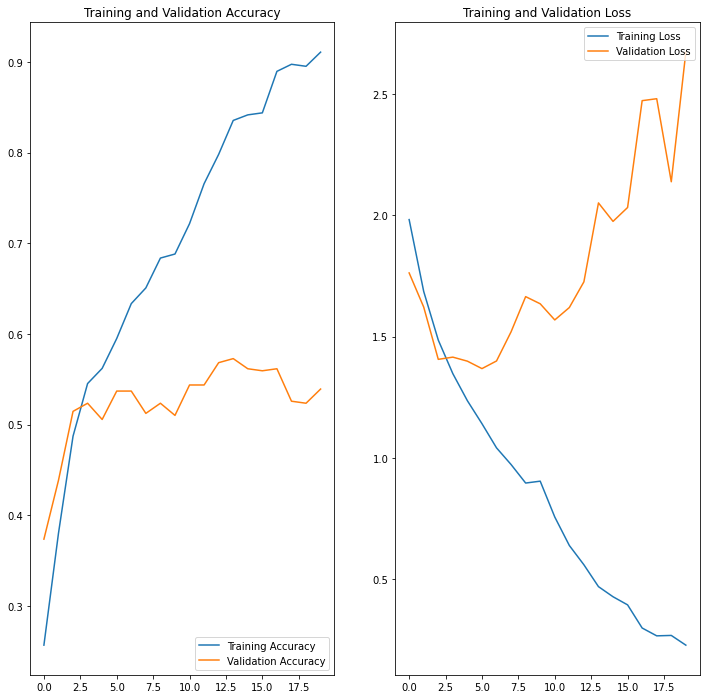

In [193]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

###Observation

At the end of 20 epochs , the model training has been completed and the training accuracy is very *high*.In general ,This is more likely due to careful control of the conditions in which the data was captured or some augmentation of the images rather than the model itself being particularly good, as it has not been **optimised**.


In [194]:
## Model summary on the performance train, validation and test set
print('Model summary')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')

Model summary
-----------------------------------------------------------------
Train accuracy on epoch 20 is 91.07142686843872%
Validation accuracy on epoch 20 is 53.91498804092407%


### Observation

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls less than 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of overfitting.

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this execise, we will use data augmentation and add Dropout to our model.

### Write your findings here

In [195]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


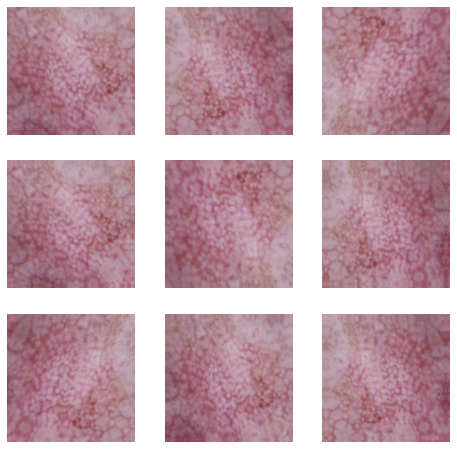

In [196]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(8, 8))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [197]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [198]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [199]:
# View the summary of all layers
model.summary()


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_7 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 45, 45, 64)      

### Training the model

In [200]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 2s 31ms/step - loss: 2.3274 - accuracy: 0.1930 - val_loss: 1.9845 - val_accuracy: 0.2260
Epoch 2/20
56/56 [==============================] - 2s 28ms/step - loss: 1.9042 - accuracy: 0.2743 - val_loss: 1.7432 - val_accuracy: 0.3647
Epoch 3/20
56/56 [==============================] - 2s 28ms/step - loss: 1.6884 - accuracy: 0.3992 - val_loss: 1.5464 - val_accuracy: 0.4564
Epoch 4/20
56/56 [==============================] - 2s 28ms/step - loss: 1.4875 - accuracy: 0.4794 - val_loss: 1.7084 - val_accuracy: 0.4161
Epoch 5/20
56/56 [==============================] - 2s 28ms/step - loss: 1.5230 - accuracy: 0.4579 - val_loss: 1.4163 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 2s 28ms/step - loss: 1.3858 - accuracy: 0.5048 - val_loss: 1.4341 - val_accuracy: 0.5347
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3640 - accuracy: 0.5290 - val_loss: 1.3870 - val_accuracy: 0.5347
Epoch 8/20
56

### Visualizing the results

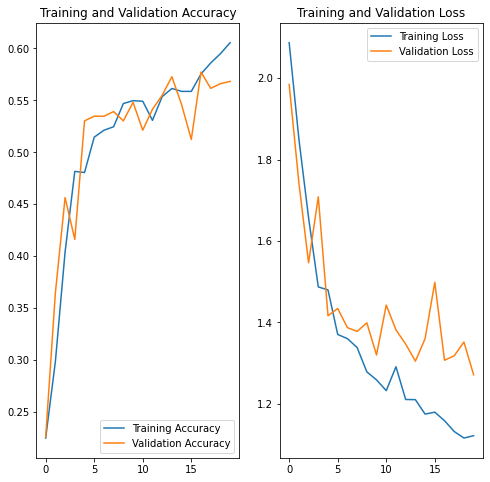

In [201]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [202]:
## Model summary on the performance train, validation and test set
print('Model summary after adding the Dense layer')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')

Model summary after adding the Dense layer
-----------------------------------------------------------------
Train accuracy on epoch 20 is 60.546875%
Validation accuracy on epoch 20 is 56.82326555252075%


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [203]:
## Your code goes here.

print(x_train_ds.class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [204]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [205]:
path_to_training_dataset=str(data_dir_train)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+'/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE64EB69F28>: 100%|██████████| 500/500 [00:15<00:00, 32.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5F1C72BE0>:   0%|          | 1/500 [00:00<01:03,  7.91 Samples/s]

Initialised with 376 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE64EA36438>: 100%|██████████| 500/500 [00:16<00:00, 31.00 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5F16F5A90>: 100%|██████████| 500/500 [00:15<00:00, 31.38 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE64EB75208>: 100%|██████████| 500/500 [01:26<00:00,  5.76 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1019x717 at 0x7FE663FF4240>: 100%|██████████| 500/500 [01:13<00:00,  6.84 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5F0408BE0>: 100%|██████████| 500/500 [00:15<00:00, 31.26 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE64E9A7940>: 100%|██████████| 500/500 [00:38<00:00, 13.06 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE5F0408EF0>:   0%|          | 1/500 [00:00<00:50,  9.84 Samples/s]

Initialised with 181 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE585762780>: 100%|██████████| 500/500 [00:15<00:00, 32.23 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to /content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE698C60A20>: 100%|██████████| 500/500 [00:15<00:00, 31.75 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [206]:
from glob import glob
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [207]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new=path_list
path_list

['/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028735.jpg_32851d51-7437-49d8-8306-0e88e97a4018.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0032114.jpg_dd4384ca-e160-46e3-aa7b-1c23234f9a68.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_507ed0aa-5d58-48b9-bd47-4fb5f3abc0f3.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030442.jpg_4e732613-22de-4535-8734-c3444ab5a9d9.jpg',
 '/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029962.jpg_2eb94d65-f1a1-4724-a5cf-75d8037677ad.jpg',


In [208]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [210]:
del dict
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [211]:
original_df=pd.DataFrame()
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [40]:
new_df['Label'].value_counts()

pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
dermatofibroma                500
basal cell carcinoma          500
nevus                         500
actinic keratosis             500
vascular lesion               500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [212]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [213]:
data_dir_train=pathlib.Path("/content/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [214]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [215]:
## your code goes here
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [218]:
## your code goes here

## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [219]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_15 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_8 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 45, 45, 64)      

#### **Todo:**  Train your model

In [220]:
epochs = 50
## Your code goes here, use 50 epochs.
##epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 33s 188ms/step - loss: 2.1825 - accuracy: 0.1863 - val_loss: 1.5526 - val_accuracy: 0.4053
Epoch 2/50
169/169 [==============================] - 33s 189ms/step - loss: 1.5532 - accuracy: 0.4122 - val_loss: 1.4461 - val_accuracy: 0.4729
Epoch 3/50
169/169 [==============================] - 32s 187ms/step - loss: 1.4067 - accuracy: 0.4635 - val_loss: 1.3631 - val_accuracy: 0.4781
Epoch 4/50
169/169 [==============================] - 33s 187ms/step - loss: 1.3347 - accuracy: 0.4928 - val_loss: 1.3374 - val_accuracy: 0.4937
Epoch 5/50
169/169 [==============================] - 32s 187ms/step - loss: 1.2908 - accuracy: 0.5050 - val_loss: 1.3965 - val_accuracy: 0.4967
Epoch 6/50
169/169 [==============================] - 33s 187ms/step - loss: 1.2444 - accuracy: 0.5272 - val_loss: 1.2965 - val_accuracy: 0.5033
Epoch 7/50
169/169 [==============================] - 33s 187ms/step - loss: 1.2266 - accuracy: 0.5279 - val_loss: 1.3163 - val_ac

#### **Todo:**  Visualize the model results

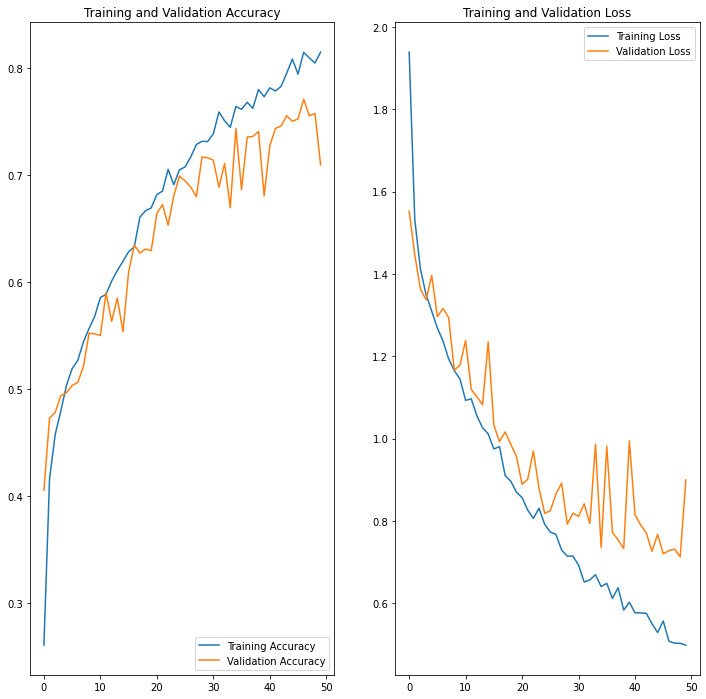

In [221]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [222]:
## Model summary on the performance train, validation and test set
print('Model summary after class rebalance')
print('-----------------------------------------------------------------')
print('Train accuracy on epoch',epochs,'is',str(100*(acc[epochs-1]))+'%')
print('Validation accuracy on epoch',epochs,'is',str(100*(val_acc[epochs-1]))+'%')

Model summary after class rebalance
-----------------------------------------------------------------
Train accuracy on epoch 50 is 81.52819275856018%
Validation accuracy on epoch 50 is 70.97253203392029%
